In [1]:
!pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install flask


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from flask import Flask, request, jsonify

# Explonatory Data Analyse (EDA) 

In [4]:
# Load your dataset
data = pd.read_csv("transactional-sample.csv")

In [5]:
data_copy = data.copy()

### Visao Geral

In [6]:
data_copy.dtypes

transaction_id          int64
merchant_id             int64
user_id                 int64
card_number            object
transaction_date       object
transaction_amount    float64
device_id             float64
has_cbk                  bool
dtype: object

In [7]:
data_copy.head(20)

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
0,21320398,29744,97051,434505******9116,2019-12-01T23:16:32.812632,374.56,285475.0,False
1,21320399,92895,2708,444456******4210,2019-12-01T22:45:37.873639,734.87,497105.0,True
2,21320400,47759,14777,425850******7024,2019-12-01T22:22:43.021495,760.36,NaN,False
3,21320401,68657,69758,464296******3991,2019-12-01T21:59:19.797129,2556.13,NaN,True
4,21320402,54075,64367,650487******6116,2019-12-01T21:30:53.347051,55.36,860232.0,False
5,21320403,59566,40759,516292******8220,2019-12-01T21:25:53.374213,60.49,192705.0,False
6,21320404,20917,25661,650485******9310,2019-12-01T21:25:19.532243,318.37,760932.0,False
7,21320405,56107,81152,650516******9201,2019-12-01T21:24:05.608374,188.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01T21:13:21.529999,352.77,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01T21:04:55.066909,345.68,486.0,True


### Ocorrencia de Chargebacks

In [8]:
# Contar a ocorrência de True e False
count_true_false = data_copy['has_cbk'].value_counts()

In [9]:
count_true_false

has_cbk
False    2808
True      391
Name: count, dtype: int64

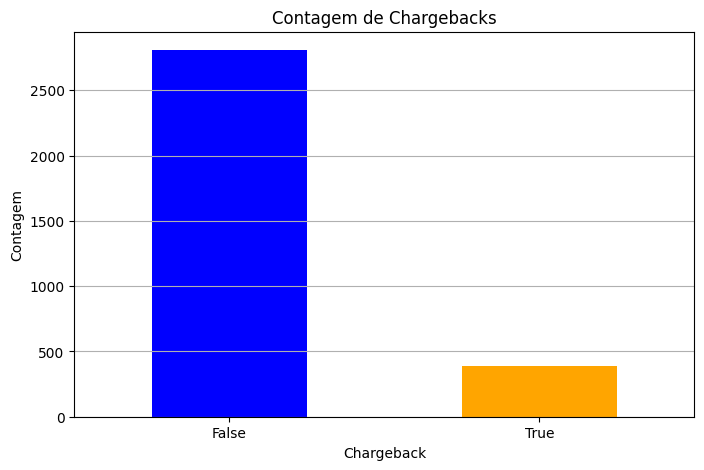

In [10]:
# Criar gráfico de barras
plt.figure(figsize=(8, 5))
count_true_false.plot(kind='bar', color=['blue', 'orange'])
plt.title('Contagem de Chargebacks')
plt.xlabel('Chargeback')
plt.ylabel('Contagem')
plt.xticks(rotation=0)  # Rotaciona os rótulos do eixo x para ficarem na horizontal
plt.grid(axis='y')  # Adiciona grid nas linhas do eixo y
plt.show()

### Descrição Estatítica das Transições Monetárias

In [11]:
data_copy['transaction_amount'].describe()

count    3199.000000
mean      767.812904
std       889.095904
min         1.220000
25%       205.235000
50%       415.940000
75%       981.680000
max      4097.210000
Name: transaction_amount, dtype: float64

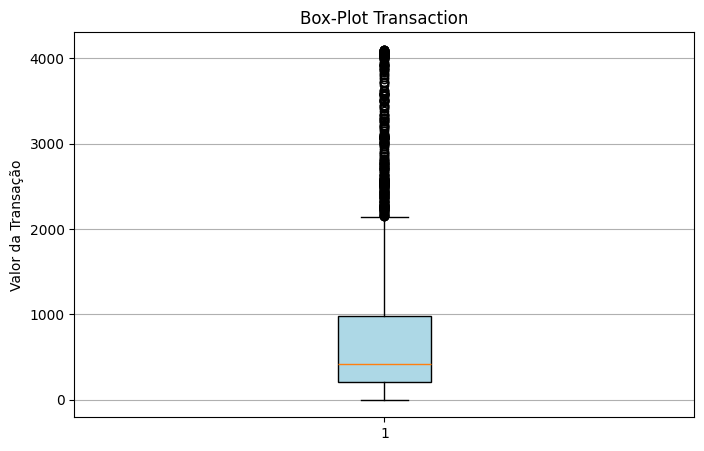

In [12]:
# Criar o box-plot para 'transaction_amount'
plt.figure(figsize=(8, 5))
plt.boxplot(data_copy['transaction_amount'], patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Box-Plot Transaction')
plt.ylabel('Valor da Transação')
plt.grid(axis='y')  # Adiciona grid nas linhas do eixo y
plt.show()

In [13]:
# Contar valores nulos e vazios
def count_nulls_and_empty(dataframe):
    null_counts = dataframe.isnull().sum()  # Contar nulos
    empty_counts = (dataframe == '').sum()   # Contar strings vazias
    
    # Criar um DataFrame com os resultados
    summary = pd.DataFrame({
        'Null Count': null_counts,
        'Empty Count': empty_counts
    })
    
    return summary

# Chamar a função e exibir o resultado
result = count_nulls_and_empty(data_copy)

print(result)

                    Null Count  Empty Count
transaction_id               0            0
merchant_id                  0            0
user_id                      0            0
card_number                  0            0
transaction_date             0            0
transaction_amount           0            0
device_id                  830            0
has_cbk                      0            0


# Antifraud Requirements

### Requirement I: Reject transaction if user is trying too many transactions in a row

In [14]:
data_copy_filter = data_copy[data_copy['user_id'] == 81152]

In [15]:
data_copy_filter_copy = data_copy_filter.copy()

In [16]:
data_copy_filter_copy

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
7,21320405,56107,81152,650516******9201,2019-12-01T21:24:05.608374,188.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01T21:13:21.529999,352.77,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01T21:04:55.066909,345.68,486.0,True
13,21320411,56107,81152,650516******7004,2019-12-01T20:36:55.091278,32.86,486.0,True


In [17]:
# Converter a coluna de data para datetime
data_copy_filter_copy['transaction_date'] = pd.to_datetime(data_copy_filter_copy['transaction_date'])

In [18]:
data_copy_filter_copy.sort_values(by='transaction_date', inplace=True)

In [19]:
data_copy_filter_copy

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk
13,21320411,56107,81152,650516******7004,2019-12-01 20:36:55.091278,32.86,486.0,True
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55.066909,345.68,486.0,True
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:21.529999,352.77,486.0,True
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:05.608374,188.68,486.0,True


In [20]:
data_copy_filter_copy['time_diff'] = data_copy_filter_copy.groupby('user_id')['transaction_date'].diff()

In [21]:
data_copy_filter_copy

,transaction_id,merchant_id,user_id,card_number,transaction_date,transaction_amount,device_id,has_cbk,time_diff
13,21320411,56107,81152,650516******7004,2019-12-01 20:36:55.091278,32.86,486.0,True,NaT
9,21320407,56107,81152,650516******9201,2019-12-01 21:04:55.066909,345.68,486.0,True,0 days 00:27:59.975631
8,21320406,56107,81152,650516******9201,2019-12-01 21:13:21.529999,352.77,486.0,True,0 days 00:08:26.463090
7,21320405,56107,81152,650516******9201,2019-12-01 21:24:05.608374,188.68,486.0,True,0 days 00:10:44.078375


In [22]:
tempo=timedelta(minutes=30)
frequencia = data_copy_filter_copy[data_copy_filter_copy['time_diff'] <= tempo].groupby('user_id').size()

In [23]:
frequencia

user_id
81152    3
dtype: int64

In [24]:
def volume_pedidos_curto_intervalo(data, tempo=timedelta(minutes=20)):

    # Converter a coluna de data para datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])

    data.sort_values(by='transaction_date', inplace=True)
    data['time_diff'] = data.groupby('user_id')['transaction_date'].diff()
    frequencia = data[data['time_diff'] <= tempo].groupby('user_id').size()
    
    return frequencia[frequencia > 1]

In [25]:
# Executar as funções de análise
volume_pedidos = volume_pedidos_curto_intervalo(data)

In [26]:
print("Volume de pedidos em curto intervalo de tempo:\n", volume_pedidos)

Volume de pedidos em curto intervalo de tempo:
 user_id
5541     2
9669     2
9853     3
11750    3
17807    2
21768    3
31819    2
40779    3
42677    2
49106    2
53850    2
55630    2
56877    3
67519    2
69588    3
75710    6
76819    3
77959    3
79054    6
81152    2
88553    2
91637    4
92259    2
96025    5
dtype: int64


### Requirement II: Reject transaction if a user had a chargeback before

In [27]:
# Contas com muitos chargebacks
def contas_com_chargebacks(data):
    
    chargebacks = data[data['has_cbk'] == True]
    contagem_chargebacks = chargebacks['user_id'].value_counts()
    
    return contagem_chargebacks[contagem_chargebacks > 1]


In [28]:
contas_chargebacks = contas_com_chargebacks(data)

In [29]:
print("\nContas com muitos chargebacks:\n", contas_chargebacks)


Contas com muitos chargebacks:
 user_id
11750    25
91637    19
79054    15
96025    13
78262    12
         ..
35138     2
21233     2
24543     2
52129     2
12678     2
Name: count, Length: 78, dtype: int64


### Requirement III: Reject transactions above a certain amount in a given period

In [30]:
def should_deny_transaction(transaction_amount, transaction_date, max_amount, start_time, end_time):

    # Obtém a hora da transação
    transaction_hour = transaction_date.hour
    
    return transaction_amount > max_amount and (transaction_hour >= start_time or transaction_hour < end_time)


In [31]:
def check_transaction(data):
    MAX_AMOUNT = 1000  # Exemplo de valor máximo permitido
    START_TIME = 18    # 18:00
    END_TIME = 6       # 06:00

    # Converter a coluna de data para datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])
    
    # Converte a string de data e hora para um objeto datetime
    transaction_hour = data['transaction_date'].dt.hour

    # Obtém a hora da transação
    #transaction_hour = transaction_time.hour

    # Verificar se a transação viola os critérios
    flag = (data['transaction_amount'] > MAX_AMOUNT) & ((transaction_hour >= START_TIME) | (transaction_hour < END_TIME))

    result = data[['transaction_id']].copy()
    result['viola_criterio'] = flag

    return result


In [32]:
transaction_check = check_transaction(data=data_copy)

In [33]:
transaction_check

,transaction_id,viola_criterio
0,21320398,False
1,21320399,False
2,21320400,False
3,21320401,True
4,21320402,False
...,...,...
3194,21323592,False
3195,21323593,False
3196,21323594,False
3197,21323595,False


In [34]:
# Contar a ocorrência de True e False
count_true_false = transaction_check['viola_criterio'].value_counts()

In [35]:
count_true_false

viola_criterio
False    2775
True      424
Name: count, dtype: int64

# What other data would you look at to try to find patterns of possible frauds?

- #### Dados externos: Nutrir com informações de Dispositivo. Empresas como a Incognia, por exemplo, pode nos fornecer informações para ter numero de reinstalações e melhor tracking do dispositivo.

- #### Geolocalização, volume de endereços cadastrados.

- #### Recência e Frequência de criações de conta.

- #### Nome do cardholder -> Ideal que coincida com o dono da conta.

# What other behaviors would we look at to try to find patterns of possible frauds?

### I. Um mesmo cartão em contas diferentes

In [36]:
def cartao_em_contas_diferentes(data):
    
    contagem_cartoes = data.groupby('card_number')['user_id'].nunique()
    
    return contagem_cartoes[contagem_cartoes > 1]


In [37]:
cartoes_diferentes = cartao_em_contas_diferentes(data)

In [38]:
print("\nUm mesmo cartão em contas diferentes:\n", cartoes_diferentes)


Um mesmo cartão em contas diferentes:
 card_number
230650******7507    2
406655******4572    2
406655******5763    2
406655******7343    2
412177******1138    2
427167******7032    2
459313******1805    2
459383******1178    2
464296******3991    2
476333******3122    2
482425******7128    2
490172******3386    2
496045******1160    4
498408******4290    2
516292******1671    2
516292******1745    2
516292******2831    2
518454******7187    2
523421******9631    2
527468******3267    2
536380******6214    2
544731******3506    2
544731******3609    2
544731******8590    2
550209******1795    2
550209******6408    2
550209******6420    3
606282******1376    2
606282******4880    2
650516******3633    2
651668******2020    2
Name: user_id, dtype: int64


### II. Um cartão em contas diferentes com chargeback em todas

In [39]:
def cartao_com_chargeback_em_todas(data):
    # Filtra apenas as transações com chargeback
    chargebacks = data[data['has_cbk'] == True]
    
    # Conta quantos usuários distintos estão associados a cada cartão
    contagem_chargebacks = chargebacks.groupby('card_number')['user_id'].nunique()
    
    # Conta o número total de usuários para cada cartão
    total_usuarios = chargebacks.groupby('card_number')['user_id'].count()
    
    # Compara se o número de usuários com chargebacks é igual ao total de usuários
    cartoes_chargeback_todos = contagem_chargebacks[contagem_chargebacks == total_usuarios]
    
    return cartoes_chargeback_todos


In [40]:
cartoes_chargeback = cartao_com_chargeback_em_todas(data)

In [41]:
print("\nUm cartão em contas diferentes com chargeback em todas:\n", cartoes_chargeback)


Um cartão em contas diferentes com chargeback em todas:
 card_number
230650******5729    1
230744******950     1
403002******5770    1
406168******2582    1
406168******6228    1
                   ..
606282******9701    1
606282******9980    1
650486******2500    1
650486******4290    1
650516******7004    1
Name: user_id, Length: 208, dtype: int64


### III. Muitas contas em um mesmo dispositivo

In [42]:
def muitas_contas_no_mesmo_dispositivo(data):
    
    contagem_dispositivos = data['device_id'].value_counts()
    
    return contagem_dispositivos[contagem_dispositivos > 1]

In [43]:
contas_dispositivo = muitas_contas_no_mesmo_dispositivo(data)

In [44]:
print("\nMuitas contas em um mesmo dispositivo:\n", contas_dispositivo)


Muitas contas em um mesmo dispositivo:
 device_id
563499.0    22
342890.0    19
101848.0    17
438940.0    14
547440.0    13
            ..
743254.0     2
701116.0     2
974574.0     2
856642.0     2
463439.0     2
Name: count, Length: 177, dtype: int64


###  IV. Muitas contas com cartões diferentes

In [45]:
def muitas_contas_cartoes_diferentes(data):
    cartoes = data.groupby('user_id')['card_number'].nunique()
    return cartoes[cartoes > 1]

In [46]:
# Executar as funções de análise
contas_cartoes_diferentes = muitas_contas_cartoes_diferentes(data)

In [47]:
# Mostrar os resultados
print("\nMuitas contas com cartões diferentes:\n", contas_cartoes_diferentes)


Muitas contas com cartões diferentes:
 user_id
1516     2
1668     2
1836     2
2708     2
2866     2
        ..
96495    2
96512    2
97611    2
99396    5
99850    2
Name: card_number, Length: 114, dtype: int64


# Implementação do Endpoint Antifraude

In [48]:
# Parametros
MAX_AMOUNT = 415
START_TIME = 18
END_TIME = 6

In [49]:
# Inicializando o aplicativo Flask
app = Flask(__name__)

In [50]:
# Simulação de banco de dados de transações (dados históricos)
data = pd.read_csv("transactional-sample.csv")
database = data.copy()

In [51]:
# Detecção de volume de pedidos em curto intervalo
def short_interval_transaction_volume(data, user_id, tempo=timedelta(minutes=30)):
    """
    Verifica se um usuário realizou múltiplas transações em um curto intervalo de tempo.

    :param data: DataFrame contendo os dados históricos de transações.
                 Deve conter as colunas 'user_id' (identificador do usuário) 
                 e 'transaction_date' (data e hora da transação).
    :param user_id: Identificador único do usuário.
    :param tempo: Intervalo de tempo para a detecção de transações em curto prazo.
                  O valor padrão é 30 minutos.
    :return: True se houver mais de uma transação no intervalo especificado, False caso contrário.
    """
    
    # Converter a coluna de data para datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])

    # Filtrar transações do usuário
    user_transactions = data[data['user_id'] == user_id].copy()

    # Ordenar por data da transação
    user_transactions.sort_values(by='transaction_date', inplace=True)

    # Calcular a diferença de tempo entre transações
    user_transactions['time_diff'] = user_transactions.groupby('user_id')['transaction_date'].diff()

    # Contar quantas transações ocorrem dentro do intervalo especificado
    frequency = user_transactions[user_transactions['time_diff'] <= tempo].shape[0]

    # Retorna True se houver mais de uma transação no intervalo
    return (frequency > 1)

# Verifica se a transação deve ser negada com base no valor e no horário
def should_deny_transaction(transaction_amount, transaction_date, max_amount, start_time, end_time):
    """
    Verifica se a transação deve ser negada com base no valor e no horário.

    :param transaction_amount: Valor da transação
    :param transaction_hour: Hora da transação (como um inteiro de 0 a 23)
    :param max_amount: Valor máximo permitido para a transação
    :param start_time: Hora de início do intervalo (como um inteiro de 0 a 23)
    :param end_time: Hora de fim do intervalo (como um inteiro de 0 a 23)
    :return: True se a transação deve ser negada, False caso contrário
    """

    # Obtém a hora da transação
    transaction_hour = transaction_date.hour
    
    return (transaction_amount > max_amount) and ((transaction_hour >= start_time) or (transaction_hour < end_time))


# Função para verificar chargebacks anteriores de um usuário
def user_with_chargebacks(data, user_id):
    """
    Verifica se um usuário possui chargebacks anteriores.

    :param data: DataFrame contendo os dados históricos de transações.
                 Deve conter as colunas 'user_id' (identificador do usuário) 
                 e 'has_cbk' (indicador de chargeback, com valores booleanos).
    :param user_id: Identificador único do usuário.
    :return: True se o usuário tiver pelo menos um chargeback, False caso contrário.
    """
    
    return len(data[(data['user_id'] == user_id) & (data['has_cbk'] == True)]) > 0

In [52]:
@app.route('/analisar_transacao', methods=['POST'])

def analisar_transacao():
    # Receber a transação como JSON
    transacao = request.json

    # Extraindo informações da transação recebida
    transaction_id = transacao.get('transaction_id')
    merchant_id = transacao.get('merchant_id')
    user_id = transacao.get('user_id')
    card_number = transacao.get('card_number')
    transaction_date = pd.to_datetime(transacao.get('transaction_date'))
    transaction_amount = transacao.get('transaction_amount')
    device_id = transacao.get('device_id')



    # Requisição 1: Verificar se o usuário tem chargebacks anteriores
    if short_interval_transaction_volume(data, user_id, tempo=timedelta(minutes=30)):
        return jsonify({
            "transaction_id": transaction_id,
            "recommendation": "deny"
        })
    
    # Requisição 2: Verificar se o usuário tem chargebacks anteriores
    if user_with_chargebacks(data, user_id):
        return jsonify({
            "transaction_id": transaction_id,
            "recommendation": "deny"
        })

    # Requisição 3: Rejeitar transações acima de um certo valor em um determinado período
    if should_deny_transaction(transaction_amount, transaction_date, MAX_AMOUNT, START_TIME, END_TIME):
        return jsonify({"transaction_id": transaction_id, "recommendation": "deny"})
        
    
    # Se não houver problema, você pode adicionar mais lógica aqui
    return jsonify({
        "transaction_id": transaction_id,
        "recommendation": "approve"
    })

In [53]:
# Executando o servidor Flask
if __name__ == '__main__':
    app.run(port=5001)  # Troque para uma porta diferente, como 5001

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5001
Press CTRL+C to quit
127.0.0.1 - - [24/Oct/2024 14:59:36] "POST /analisar_transacao HTTP/1.1" 200 -


# Abra o terminal para avaliar o output do endpoint


curl -X POST http://127.0.0.1:5001/analisar_transacao \
-H "Content-Type: application/json" \
-d '{
  "transaction_id": 2342357,
  "merchant_id": 29744,
  "user_id": 97051,
  "card_number": "434505******9116",
  "transaction_date": "2019-11-30T23:16:32.812632",
  "transaction_amount": 1000,
  "device_id": 285475
}'

# Fim!